# Visual Analysis — Upstart13 Case Study

This notebook reads the **published** tables produced by the PySpark pipeline and generates two simple charts for the client presentation:

1. **Top revenue-generating color by year**  
2. **Average lead time (business days) by product category**

> The notebook **does not** re-run the ETL. It only visualizes results from `/out/publish/`.
> Run `01 → 05` PySpark scripts first.


In [1]:
from pyspark.sql import SparkSession, functions as F

spark = (SparkSession.builder
         .appName("upstart13_visuals")
         .getOrCreate())

print("Spark version:", spark.version)


Spark version: 3.5.0


In [2]:
import pandas as pd

# Configure pandas display to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = None

from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

# Derive project root (one level up if notebook directory)
CWD = Path.cwd().resolve()
if CWD.name == 'notebooks':
    PROJECT_ROOT = CWD.parent
else:
    PROJECT_ROOT = CWD

publish_candidates = [
    PROJECT_ROOT / 'out' / 'publish(gold)',
    PROJECT_ROOT / 'out' / 'publish'
]
for candidate in publish_candidates:
    if candidate.exists():
        PUBLISH = candidate
        break
else:
    raise FileNotFoundError('Publish directory not found. Run pipeline scripts first.')

paths = {
    'publish_orders': str(PUBLISH / 'publish_orders'),
    'publish_product': str(PUBLISH / 'publish_product'),
    'analysis_top_color_by_year': str(PUBLISH / 'analysis_top_color_by_year'),
    'analysis_avg_lead_by_category': str(PUBLISH / 'analysis_avg_lead_by_category'),
}

for key, value in paths.items():
    print(f"{key}: {value}")


publish_orders: C:\Users\Andre\Desktop\upstart13_pipeline\out\publish(gold)\publish_orders
publish_product: C:\Users\Andre\Desktop\upstart13_pipeline\out\publish(gold)\publish_product
analysis_top_color_by_year: C:\Users\Andre\Desktop\upstart13_pipeline\out\publish(gold)\analysis_top_color_by_year
analysis_avg_lead_by_category: C:\Users\Andre\Desktop\upstart13_pipeline\out\publish(gold)\analysis_avg_lead_by_category


In [3]:
df_orders = spark.read.parquet(paths["publish_orders"]) 
df_product = spark.read.parquet(paths["publish_product"]) 

df_orders.printSchema()
df_product.printSchema()


root
 |-- SalesOrderID: integer (nullable = true)
 |-- SalesOrderDetailID: integer (nullable = true)
 |-- OrderQty: integer (nullable = true)
 |-- ProductID: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- UnitPriceDiscount: double (nullable = true)
 |-- IsReturn: boolean (nullable = true)
 |-- LineTotal: double (nullable = true)
 |-- OrderDate: timestamp (nullable = true)
 |-- ShipDate: timestamp (nullable = true)
 |-- OnlineOrderFlag: boolean (nullable = true)
 |-- AccountNumber: string (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- SalesPersonID: integer (nullable = true)
 |-- TotalOrderFreight: double (nullable = true)
 |-- LeadTimeInBusinessDays: integer (nullable = true)
 |-- TotalLineExtendedPrice: double (nullable = true)

root
 |-- ProductID: integer (nullable = true)
 |-- ProductDesc: string (nullable = true)
 |-- ProductNumber: string (nullable = true)
 |-- MakeFlag: boolean (nullable = true)
 |-- Color: string (nullable = true)
 |-

## 1) Top revenue-generating color by year


,OrderYear,Color,Revenue
0,2021,Red,"6,019,394.41"
1,2022,Black,"13,917,844.90"
2,2023,Black,"15,031,199.73"
3,2024,Yellow,"6,360,243.00"


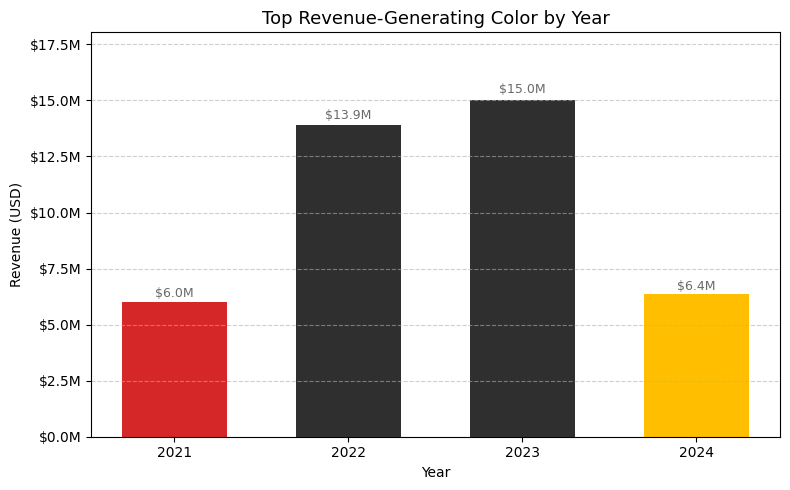

In [4]:
from pathlib import Path
from pyspark.sql import Window

_COLOR_MAP = {
    'black': '#2F2F2F',
    'red': '#D62728',
    'yellow': '#FFBF00',
    'white': '#F7F7F7',
    'silver': '#C0C0C0',
    'blue': '#1F77B4',
    'green': '#2CA02C',
    'orange': '#FF7F0E',
    'purple': '#9467BD',
    'pink': '#E377C2',
    'multi': '#8C564B',
    'gray': '#7F7F7F',
    'grey': '#7F7F7F',
}

def normalize_color(name: str | None) -> str:
    if not name:
        return '#999999'
    cleaned = name.strip().lower()
    if cleaned in ('n/a', 'na', 'none'):
        return '#999999'
    if cleaned in _COLOR_MAP:
        return _COLOR_MAP[cleaned]
    if cleaned in mcolors.CSS4_COLORS:
        return mcolors.CSS4_COLORS[cleaned]
    return '#1f77b4'

analysis_top_path = Path(paths['analysis_top_color_by_year'])
if analysis_top_path.exists():
    df_top_color = spark.read.parquet(paths['analysis_top_color_by_year'])
else:
    df_orders_color = (
        df_orders.join(
            df_product.select('ProductID', 'Color'),
            on='ProductID',
            how='left'
        )
        .withColumn('OrderYear', F.year('OrderDate'))
    )
    df_top_color = (
        df_orders_color.groupBy('OrderYear', 'Color')
        .agg(F.sum('TotalLineExtendedPrice').alias('Revenue'))
    )
    window = Window.partitionBy('OrderYear').orderBy(F.desc('Revenue'))
    df_top_color = (
        df_top_color
        .withColumn('rn', F.row_number().over(window))
        .filter(F.col('rn') == 1)
        .drop('rn')
    )

pdf_top_color = df_top_color.orderBy('OrderYear').toPandas()
pdf_top_color = pdf_top_color.sort_values('OrderYear').reset_index(drop=True)

display(pdf_top_color)

plt.figure(figsize=(8, 5))
bar_colors = [normalize_color(c) for c in pdf_top_color['Color']]
bars = plt.bar(
    pdf_top_color['OrderYear'],
    pdf_top_color['Revenue'],
    color=bar_colors,
    width=0.6
)

def millions(x, pos):
    return f"${x*1e-6:,.1f}M"
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(millions))

for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        h * 1.01,
        f"${h*1e-6:,.1f}M",
        ha='center', va='bottom', fontsize=9, color='dimgray'
    )

plt.title('Top Revenue-Generating Color by Year', fontsize=13)
plt.xlabel('Year')
plt.ylabel('Revenue (USD)')
plt.xticks(pdf_top_color['OrderYear'], pdf_top_color['OrderYear'])
plt.ylim(0, pdf_top_color['Revenue'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## 2) Average Lead Time (Business Days) by Product Category


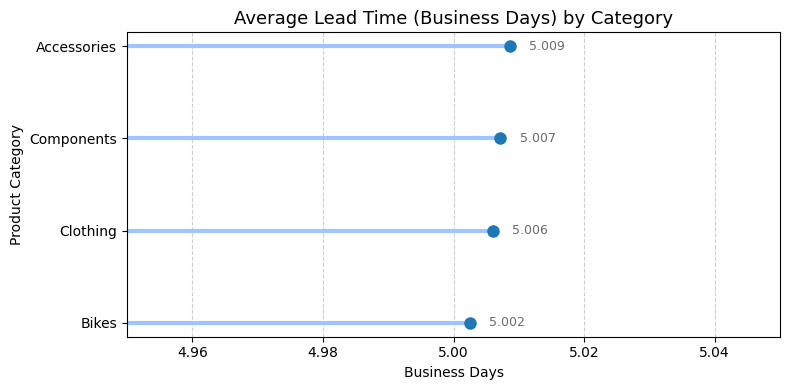

In [5]:
from pathlib import Path

analysis_lead_path = Path(paths['analysis_avg_lead_by_category'])
if analysis_lead_path.exists():
    df_lead = spark.read.parquet(paths['analysis_avg_lead_by_category'])
else:
    df_orders_cat = df_orders.join(
        df_product.select('ProductID', 'ProductCategoryName'),
        on='ProductID',
        how='left'
    )
    df_lead = (
        df_orders_cat
        .groupBy('ProductCategoryName')
        .agg(F.avg('LeadTimeInBusinessDays').alias('AvgLeadTimeInBusinessDays'))
    )

pdf_lead = df_lead.orderBy('AvgLeadTimeInBusinessDays').toPandas()
pdf_lead = pdf_lead.sort_values('AvgLeadTimeInBusinessDays').reset_index(drop=True)

plt.figure(figsize=(8, 4))
plt.hlines(
    y=pdf_lead['ProductCategoryName'].astype(str),
    xmin=4.95,
    xmax=pdf_lead['AvgLeadTimeInBusinessDays'],
    color='#A0C4FF',
    linewidth=3
)
plt.plot(
    pdf_lead['AvgLeadTimeInBusinessDays'],
    pdf_lead['ProductCategoryName'].astype(str),
    'o', color='#1F77B4', markersize=8
)
for x, y in zip(pdf_lead['AvgLeadTimeInBusinessDays'], pdf_lead['ProductCategoryName']):
    plt.text(x + 0.003, y, f"{x:.3f}", va='center', fontsize=9, color='dimgray')

plt.title('Average Lead Time (Business Days) by Category', fontsize=13)
plt.xlabel('Business Days')
plt.ylabel('Product Category')
plt.xlim(4.95, 5.05)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Key takeaways
- **Black** dominates revenue in 2022–2023, while **Yellow** leads 2024 after Red's spike in 2021.
- Lead times stay near **5 business days** across categories, signalling consistent fulfillment regardless of product type.

In [6]:
# Stop Spark
spark.stop()
print("Analysis complete!")

Analysis complete!
